
... ***CURRENTLY UNDER DEVELOPMENT*** ...


# Compare HyCReeW-Q results from hourly waves and from hydrographs
## Validation of the methodology to be used in the climate emulator

In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# common
import os
import os.path as op

# pip
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..', '..'))

from teslakit.database import Database


In [2]:

p_data = r'/Users/albacid/Projects/TeslaKit_projects'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')

# --------------------------------------
# N, S, E profiles
pN = 28 #(36,22)
pS = 8  #(13,1)
pE = 16 #(21,14)

In [3]:
hist_Q_storms_N = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_storms_N' + str(pN) + '.nc'))
hist_Q_storms_S = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_storms_S' + str(pS) + '.nc'))
hist_Q_storms_E = xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_storms_E' + str(pE) + '.nc'))

hist_Q_storms_N['Qinv']=(('time'), hist_Q_storms_N.Qinv.values)
hist_Q_storms_N = hist_Q_storms_N.reset_coords(names='Qinv', drop=False)

hist_Q_storms_S['Qinv']=(('time'), hist_Q_storms_S.Qinv.values)
hist_Q_storms_S = hist_Q_storms_S.reset_coords(names='Qinv', drop=False)

hist_Q_storms_E['Qinv']=(('time'), hist_Q_storms_E.Qinv.values)
hist_Q_storms_E = hist_Q_storms_E.reset_coords(names='Qinv', drop=False)

print(hist_Q_storms_N)
print(hist_Q_storms_S)
print(hist_Q_storms_E)

<xarray.Dataset>
Dimensions:  (time: 349740)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-23 ... 2018-12-16T11:00:00
Data variables:
    hs       (time) float64 ...
    tp       (time) float64 ...
    bslope   (time) float64 ...
    rslope   (time) float64 ...
    rwidth   (time) float64 ...
    Zb       (time) float64 ...
    cf       (time) float64 ...
    level    (time) float64 ...
    hs_lo2   (time) float64 ...
    Q        (time) float64 ...
    Qinv     (time) float64 9.952e-05 4.635e-05 ... 6.678e-06 1.385e-05
<xarray.Dataset>
Dimensions:  (time: 349740)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-23 ... 2018-12-16T11:00:00
Data variables:
    hs       (time) float64 ...
    tp       (time) float64 ...
    bslope   (time) float64 ...
    rslope   (time) float64 ...
    rwidth   (time) float64 ...
    Zb       (time) float64 ...
    cf       (time) float64 ...
    level    (time) float64 ...
    hs_lo2   (time) float64 ...
    Q        (time) float64 ...


In [4]:
hist_Q_wavesH= xr.open_dataset(op.join(p_data, 'sites/KWAJALEIN/HYCREWW/hist_Q_wavesH.nc'))

hist_Q_wavesH_N = hist_Q_wavesH.sel(profile=pN)
hist_Q_wavesH_S = hist_Q_wavesH.sel(profile=pS)
hist_Q_wavesH_E = hist_Q_wavesH.sel(profile=pE)

print(hist_Q_wavesH)

<xarray.Dataset>
Dimensions:  (profile: 36, time: 350268)
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-16T11:00:00
  * profile  (profile) float64 1.0 2.0 3.0 4.0 5.0 ... 32.0 33.0 34.0 35.0 36.0
Data variables:
    hs       (profile, time) float64 ...
    tp       (profile, time) float64 ...
    dir      (profile, time) float64 ...
    bslope   (profile, time) float64 ...
    rslope   (profile, time) float64 ...
    rwidth   (profile, time) float64 ...
    cf       (profile, time) float64 ...
    Zb       (profile, time) float64 ...
    level    (profile, time) float64 ...
    hs_lo2   (profile, time) float64 ...
    Q        (profile, time) float64 ...
    Qinv     (profile, time) float64 ...


### Plot

### plot Hs & Tp (Hycreww input)

(730486.0, 730851.0)

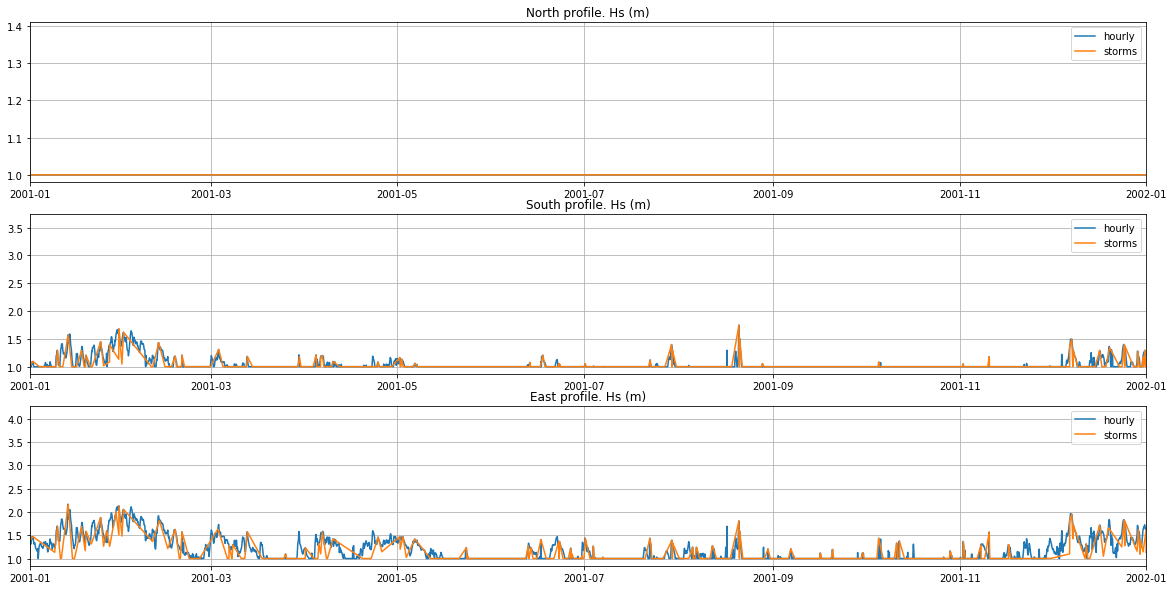

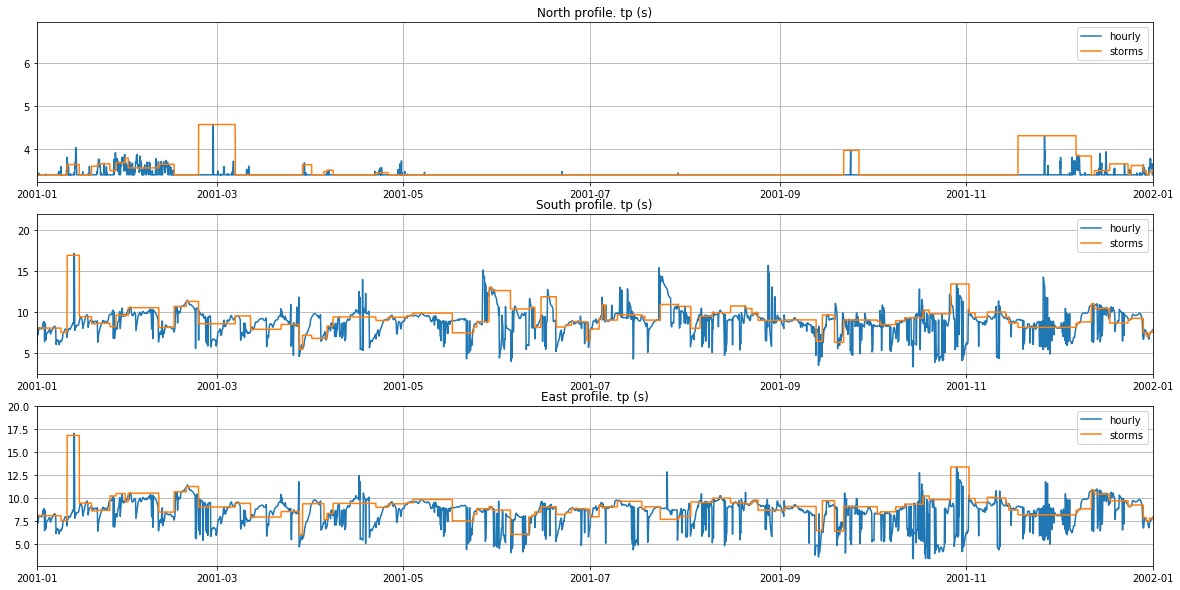

In [5]:
# plot 1 year

fig,axs = plt.subplots(3,1,figsize=(20,10))

axs[0].plot(hist_Q_wavesH_N.time, hist_Q_wavesH_N.hs.values, label='hourly')
axs[0].plot(hist_Q_storms_N.time, hist_Q_storms_N.hs.values, label='storms')
axs[0].legend()
axs[0].grid()
axs[0].title.set_text('North profile. Hs (m)')
axs[0].set_xlim(datetime(2001,1,1),datetime(2002,1,1))


axs[1].plot(hist_Q_wavesH_S.time, hist_Q_wavesH_S.hs.values, label='hourly')
axs[1].plot(hist_Q_storms_S.time, hist_Q_storms_S.hs.values, label='storms')
axs[1].legend()
axs[1].grid()
axs[1].title.set_text('South profile. Hs (m)')
axs[1].set_xlim(datetime(2001,1,1),datetime(2002,1,1))

axs[2].plot(hist_Q_wavesH_E.time, hist_Q_wavesH_E.hs.values, label='hourly')
axs[2].plot(hist_Q_storms_E.time, hist_Q_storms_E.hs.values, label='storms')
axs[2].legend()
axs[2].grid()
axs[2].title.set_text('East profile. Hs (m)')
axs[2].set_xlim(datetime(2001,1,1),datetime(2002,1,1))


fig,axs = plt.subplots(3,1,figsize=(20,10))

axs[0].plot(hist_Q_wavesH_N.time, hist_Q_wavesH_N.tp.values, label='hourly')
axs[0].plot(hist_Q_storms_N.time, hist_Q_storms_N.tp.values, label='storms')
axs[0].legend()
axs[0].grid()
axs[0].title.set_text('North profile. tp (s)')
axs[0].set_xlim(datetime(2001,1,1),datetime(2002,1,1))

axs[1].plot(hist_Q_wavesH_S.time, hist_Q_wavesH_S.tp.values, label='hourly')
axs[1].plot(hist_Q_storms_S.time, hist_Q_storms_S.tp.values, label='storms')
axs[1].legend()
axs[1].grid()
axs[1].title.set_text('South profile. tp (s)')
axs[1].set_xlim(datetime(2001,1,1),datetime(2002,1,1))

axs[2].plot(hist_Q_wavesH_E.time, hist_Q_wavesH_E.tp.values, label='hourly')
axs[2].plot(hist_Q_storms_E.time, hist_Q_storms_E.tp.values, label='storms')
axs[2].legend()
axs[2].grid()
axs[2].title.set_text('East profile. tp (s)')
axs[2].set_xlim(datetime(2001,1,1),datetime(2002,1,1))

3.4


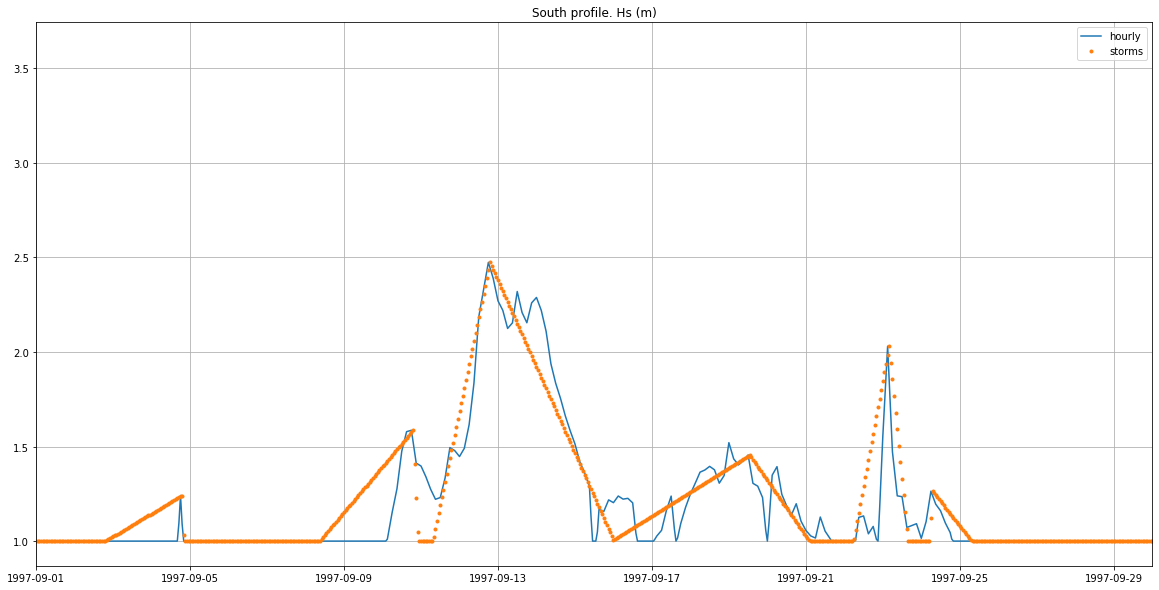

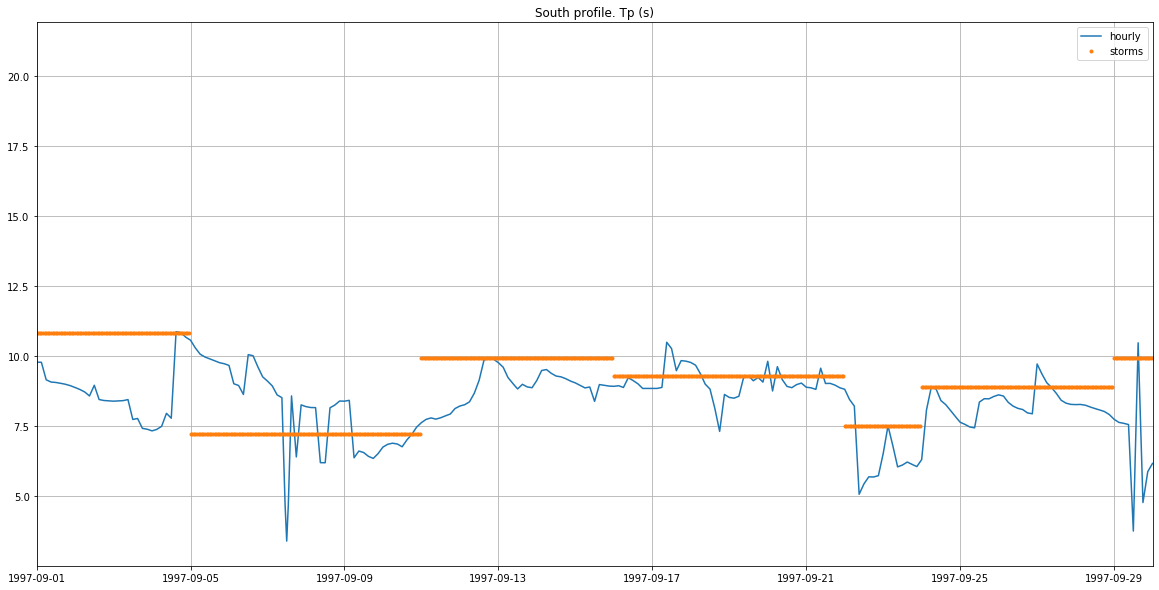

In [6]:
# plot 1 month for South profile

plt.figure(figsize=(20,10))
plt.plot(hist_Q_wavesH_S.time, hist_Q_wavesH_S.hs.values, label='hourly')
plt.plot(hist_Q_storms_S.time, hist_Q_storms_S.hs.values, '.', label='storms')
plt.legend()
plt.grid()
plt.title('South profile. Hs (m)')
plt.xlim(datetime(1997,9,1),datetime(1997,9,30))


plt.figure(figsize=(20,10))
plt.plot(hist_Q_wavesH_S.time, hist_Q_wavesH_S.tp.values, label='hourly')
plt.plot(hist_Q_storms_S.time, hist_Q_storms_S.tp.values, '.', label='storms')
plt.legend()
plt.grid()
plt.title('South profile. Tp (s)')
plt.xlim(datetime(1997,9,1),datetime(1997,9,30))

print(np.min(hist_Q_wavesH_S.tp.values))

### plot scatter

Text(0.5, 1.0, 'tp')

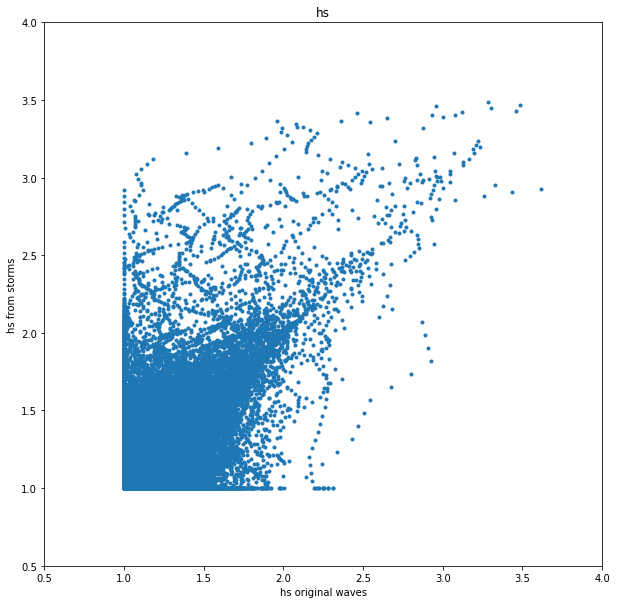

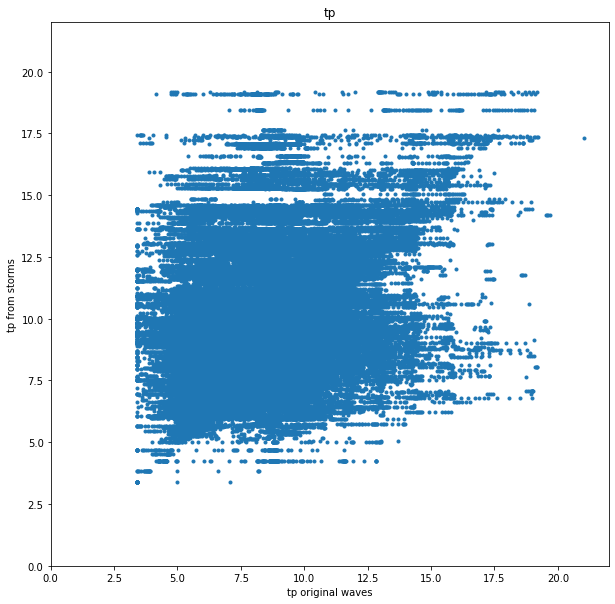

In [7]:
hist_Q_wavesH_S = hist_Q_wavesH_S.sel(time=hist_Q_storms_S.time)

var1 = 'hs'
plt.figure(figsize=(10,10))
plt.plot(hist_Q_wavesH_S[var1], hist_Q_storms_S[var1], '.')
plt.xlabel(var1 + ' original waves')
plt.ylabel(var1 + ' from storms')
plt.xlim(0.5, 4)
plt.ylim(0.5, 4)
plt.title(var1)

var1 = 'tp'
plt.figure(figsize=(10,10))
plt.plot(hist_Q_wavesH_S[var1], hist_Q_storms_S[var1], '.')
plt.xlabel(var1 + ' original waves')
plt.ylabel(var1 + ' from storms')
plt.xlim(0, 22)
plt.ylim(0, 22)
plt.title(var1)

### plot Overtopping (Hycreww output)

SystemExit: 

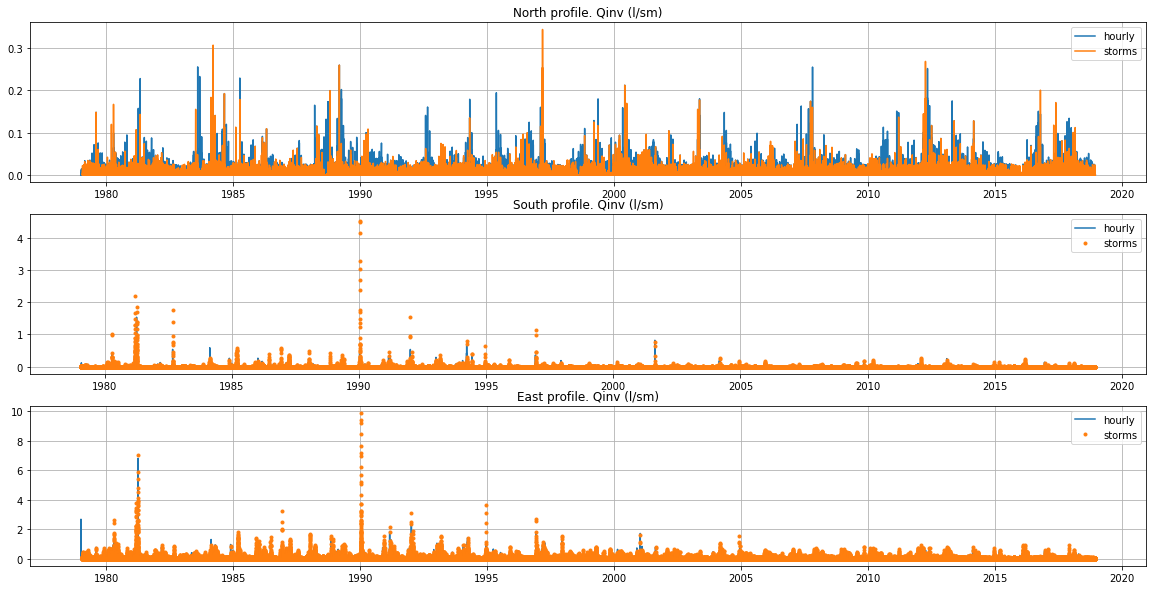

In [8]:
# plot 1 year

fig,axs = plt.subplots(3,1,figsize=(20,10))

axs[0].plot(hist_Q_wavesH_N.time, hist_Q_wavesH_N.Qinv.values, label='hourly')
axs[0].plot(hist_Q_storms_N.time, hist_Q_storms_N.Qinv.values, label='storms')
axs[0].legend()
axs[0].grid()
axs[0].title.set_text('North profile. Qinv (l/sm)')
#axs[0].set_xlim(datetime(2001,1,1),datetime(2002,1,1))
#axs[0].set_xlim(datetime(1996,1,1),datetime(2014,1,1))

axs[1].plot(hist_Q_wavesH_S.time, hist_Q_wavesH_S.Qinv.values, label='hourly')
axs[1].plot(hist_Q_storms_S.time, hist_Q_storms_S.Qinv.values, '.', label='storms')
axs[1].legend()
axs[1].grid()
axs[1].title.set_text('South profile. Qinv (l/sm)')
#axs[1].set_xlim(datetime(1996,1,1),datetime(2014,1,1))

axs[2].plot(hist_Q_wavesH_E.time, hist_Q_wavesH_E.Qinv.values, label='hourly')
axs[2].plot(hist_Q_storms_E.time, hist_Q_storms_E.Qinv.values, '.', label='storms')
axs[2].legend()
axs[2].grid()
axs[2].title.set_text('East profile. Qinv (l/sm)')
#axs[2].set_xlim(datetime(1996,1,1),datetime(2014,1,1))

sys.exit()

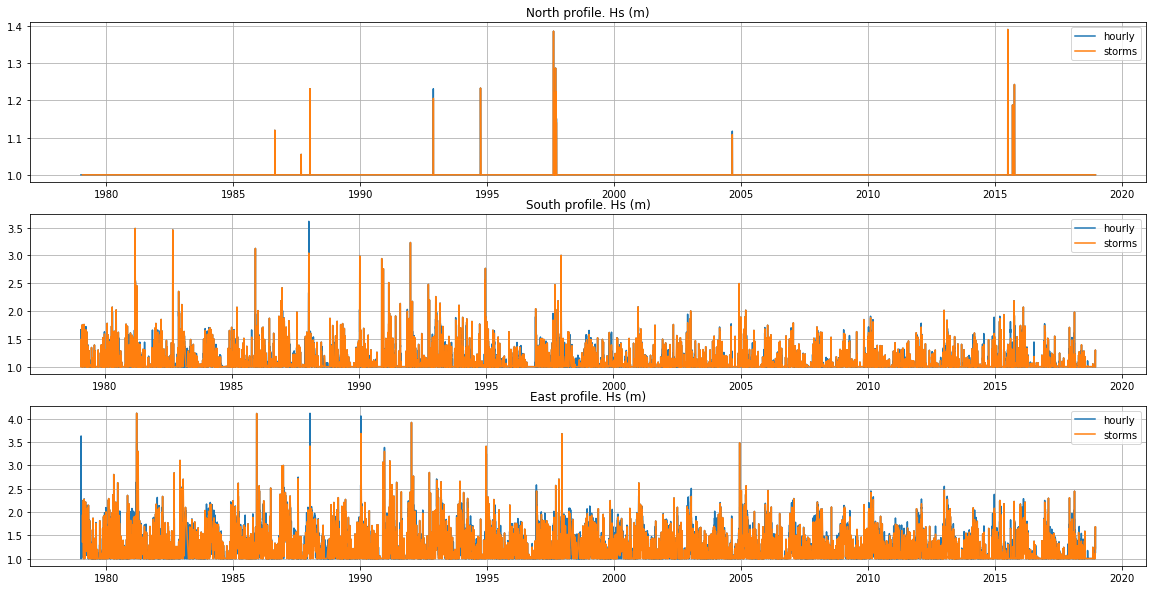

In [9]:
fig,axs = plt.subplots(3,1,figsize=(20,10))

axs[0].plot(hist_Q_wavesH_N.time, hist_Q_wavesH_N.hs.values, label='hourly')
axs[0].plot(hist_Q_storms_N.time, hist_Q_storms_N.hs.values, label='storms')
axs[0].legend()
axs[0].grid()
axs[0].title.set_text('North profile. Hs (m)')
#axs[0].set_xlim(datetime(1989,1,1),datetime(1990,1,1))

axs[1].plot(hist_Q_wavesH_S.time, hist_Q_wavesH_S.hs.values, label='hourly')
axs[1].plot(hist_Q_storms_S.time, hist_Q_storms_S.hs.values, label='storms')
axs[1].legend()
axs[1].grid()
axs[1].title.set_text('South profile. Hs (m)')
#axs[1].set_xlim(datetime(1989,1,1),datetime(1990,1,1))

axs[2].plot(hist_Q_wavesH_E.time, hist_Q_wavesH_E.hs.values, label='hourly')
axs[2].plot(hist_Q_storms_E.time, hist_Q_storms_E.hs.values, label='storms')
axs[2].legend()
axs[2].grid()
axs[2].title.set_text('East profile. Hs (m)')
#axs[2].set_xlim(datetime(1989,1,1),datetime(1990,1,1))




Text(0.5, 1.0, 'South profile. Overtopping (l/s/m)')

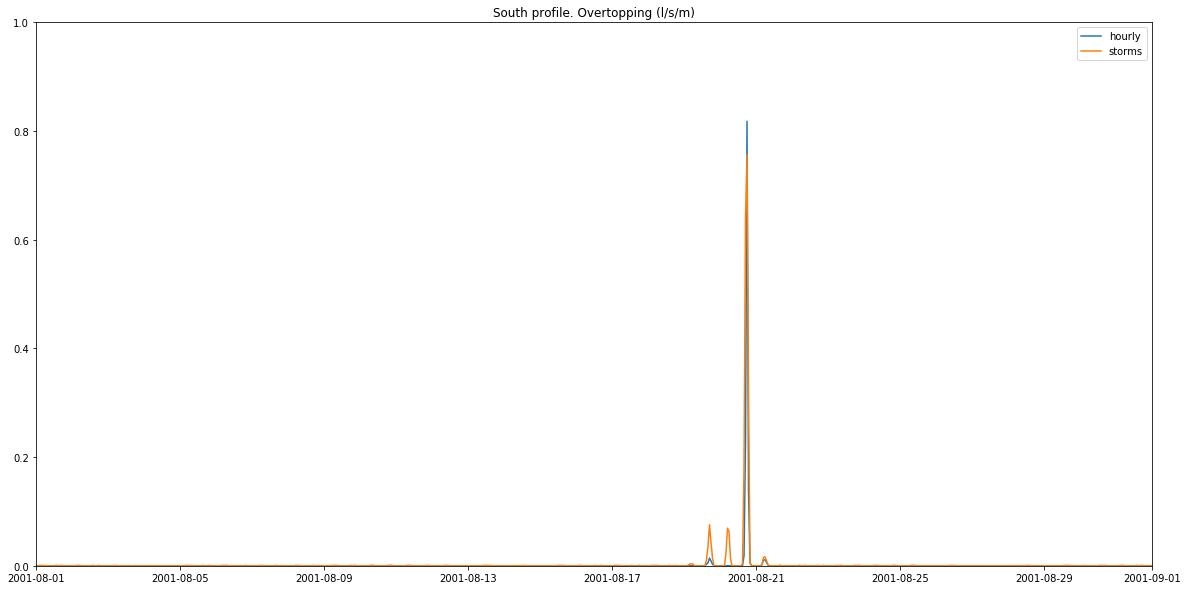

In [10]:
# plot South
plt.figure(figsize=(20,10))

plt.plot(hist_Q_wavesH_S.time, hist_Q_wavesH_S.Qinv.values, label='hourly')
plt.plot(hist_Q_storms_S.time, hist_Q_storms_S.Qinv.values, label='storms')
#plt.plot(hist_Q_storms_S.time, abs(hist_Q_wavesH_S.Qinv.values-hist_Q_storms_S.Qinv.values), '.r', label='dif')
#plt.xlim(datetime(1989,1,1),datetime(1991,1,1))
plt.xlim(datetime(2001,8,1),datetime(2001,9,1))
plt.ylim(0,1)
plt.legend()
plt.title('South profile. Overtopping (l/s/m)')

In [11]:
# Select coincident values
#hist_Q_wavesH_N = hist_Q_wavesH_N.sel(time=hist_Q_storms_N.time)
#hist_Q_wavesH_S = hist_Q_wavesH_S.sel(time=hist_Q_storms_S.time)
#hist_Q_wavesH_E = hist_Q_wavesH_E.sel(time=hist_Q_storms_E.time)


hist_Q_wavesH_N = hist_Q_wavesH_N.sel(time=slice(datetime(1996,1,1), datetime(2014,1,1)))
hist_Q_wavesH_S = hist_Q_wavesH_S.sel(time=slice(datetime(1996,1,1), datetime(2014,1,1)))
hist_Q_wavesH_E = hist_Q_wavesH_E.sel(time=slice(datetime(1996,1,1), datetime(2014,1,1)))
                                                                            
hist_Q_storms_N = hist_Q_storms_N.sel(time=slice(datetime(1996,1,1), datetime(2014,1,1)))
hist_Q_storms_S = hist_Q_storms_S.sel(time=slice(datetime(1996,1,1), datetime(2014,1,1)))
hist_Q_storms_E = hist_Q_storms_E.sel(time=slice(datetime(1996,1,1), datetime(2014,1,1)))

Text(0.5, 1.0, 'East profile. Overtopping (l/s/m)')

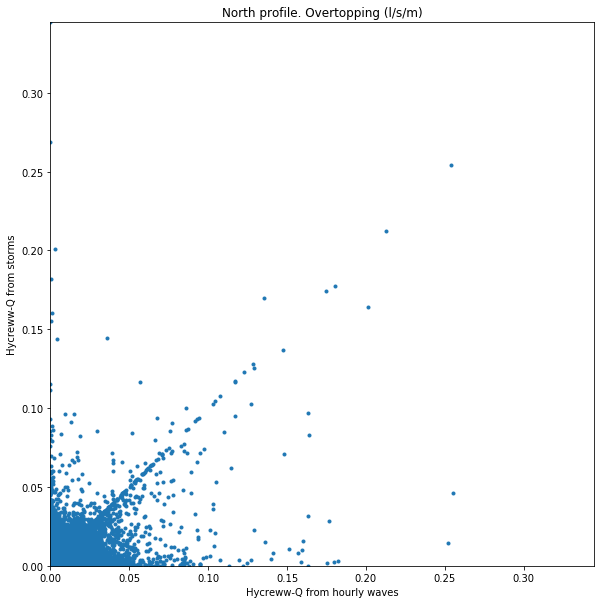

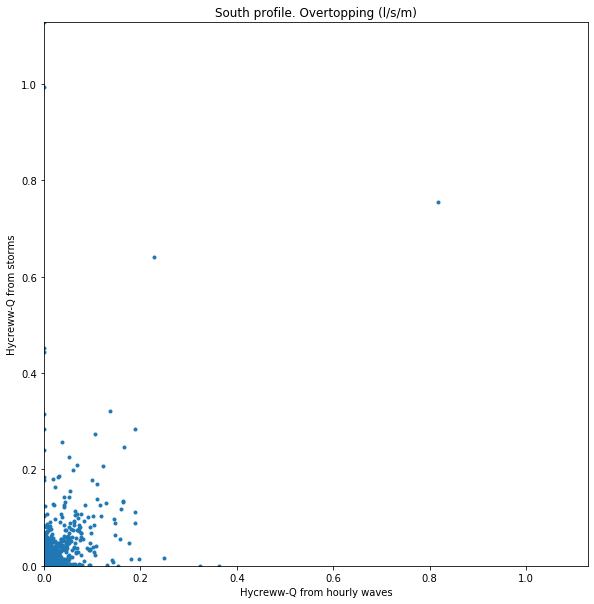

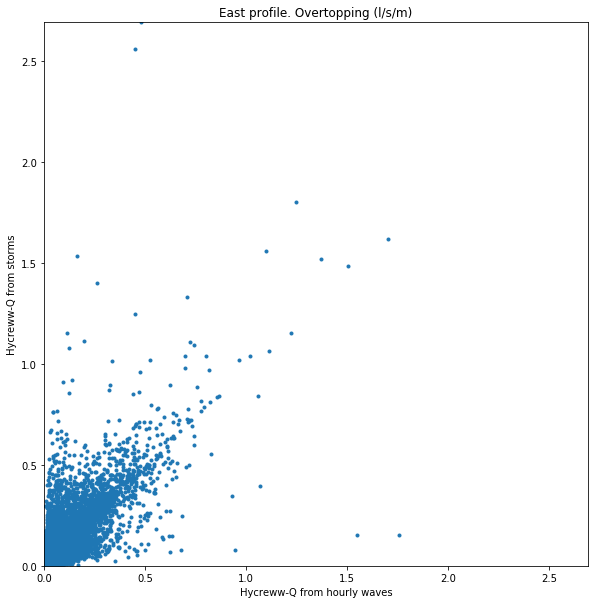

In [12]:

plt.figure(figsize=(20,10))
limits = np.max([np.nanmax(hist_Q_wavesH_N.Qinv.values), np.nanmax(hist_Q_storms_N.Qinv.values)])
plt.plot(hist_Q_wavesH_N.Qinv.values, hist_Q_storms_N.Qinv.values, '.')
plt.xlim(0, limits)
plt.ylim(0, limits)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Hycreww-Q from hourly waves')
plt.ylabel('Hycreww-Q from storms')
plt.title('North profile. Overtopping (l/s/m)')


plt.figure(figsize=(20,10))
limits = np.max([np.nanmax(hist_Q_wavesH_S.Qinv.values), np.nanmax(hist_Q_storms_S.Qinv.values)])
plt.plot(hist_Q_wavesH_S.Qinv.values, hist_Q_storms_S.Qinv.values, '.')
plt.xlim(0, limits)
plt.ylim(0, limits)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Hycreww-Q from hourly waves')
plt.ylabel('Hycreww-Q from storms')
plt.title('South profile. Overtopping (l/s/m)')

plt.figure(figsize=(20,10))
limits = np.max([np.nanmax(hist_Q_wavesH_E.Qinv.values), np.nanmax(hist_Q_storms_E.Qinv.values)])
plt.plot(hist_Q_wavesH_E.Qinv.values, hist_Q_storms_E.Qinv.values, '.')
plt.xlim(0, limits)
plt.ylim(0, limits)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('Hycreww-Q from hourly waves')
plt.ylabel('Hycreww-Q from storms')
plt.title('East profile. Overtopping (l/s/m)')